In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sim_py import leg_match
from sim_py import leg

## Load in dataframes

I have 2 seperate dataframes. One with the results of each match and one with the results of every leg. Each match and leg has statistics on checkout rate and treble hitting rate.

In [2]:
match_df = pd.read_excel("../processing/df_simple.xlsx", index_col=False)
leg_df = pd.read_excel("../processing/df_leg.xlsx", index_col=False)

In [3]:
# Remove Grand Prix (double in) matches as these can skew the treble rates
match_df = match_df[match_df["competition"] != "World Grand Prix 2025"].reset_index(drop=True)
leg_df = leg_df[leg_df["competition"] != "World Grand Prix 2025"].reset_index(drop=True)

In [4]:
print(match_df.shape)
print(leg_df.shape)

(1608, 36)
(15569, 18)


In [5]:
match_df.tail(3)

,filename,date,date_sort,home,away,winner,home_score,away_score,competition,throw,...,away_treb_success,away_checkouts,away_darts_at_dbl,away_checkouts_100s_plus,away_highest_checkout,away_scores_100s_plus,away_scores_140s_plus,away_scores_180s,home_sp,away_sp
1605,231104,23 November,2025-11-23 19:10:00,"Price, Gerwyn","Littler, Luke",1,8,11,"Players Championship 2025, Finals",1,...,112,11.0,24.0,1,100,23,16,10,4.50,1.28
1606,231105,23 November,2025-11-23 20:05:00,"Aspinall, Nathan","Wattimena, Jermaine",0,11,2,"Players Championship 2025, Finals",0,...,62,2.0,10.0,0,70,22,10,0,1.66,2.50
1607,231106,23 November,2025-11-23 21:20:00,"Littler, Luke","Aspinall, Nathan",0,11,8,"Players Championship 2025, Finals",0,...,92,8.0,25.0,1,127,19,7,7,1.20,5.70


In [6]:
print(f"Dataframes contain all PDC matches between {match_df.loc[0, "date"]} and {match_df.loc[len(match_df)-1, "date"]} 2025.")

Dataframes contain all PDC matches between 6 February and 23 November 2025.


## Create individual player dictionaries

In [7]:
# Extract treble rates per leg
player_stats = {}

for _, row in leg_df.iterrows():
    home = row["home"]
    away = row["away"]
    date = row["date_sort"]
    
    if home not in player_stats:
        player_stats[home] = {"dates":[], "t_rate":[], "t_attempts":[], "t_successes":[], "d_rate":[], "n_legs":[]}
    if away not in player_stats:
        player_stats[away] = {"dates":[], "t_rate":[], "t_attempts":[], "t_successes":[], "d_rate":[], "n_legs":[]}

    player_stats[home]["dates"].append(date)
    player_stats[home]["t_rate"].append(row["home_treb_rate"])
    player_stats[home]["t_attempts"].append(row["home_treb_attempt"])
    player_stats[home]["t_successes"].append(row["home_treb_success"])
    player_stats[away]["dates"].append(date)
    player_stats[away]["t_rate"].append(row["away_treb_rate"])
    player_stats[away]["t_attempts"].append(row["away_treb_attempt"])
    player_stats[away]["t_successes"].append(row["away_treb_success"])

In [8]:
# Extract double checkouts and number of legs per game
for _, row in match_df.iterrows():
    home = row["home"]
    away = row["away"]
    n_legs = row["home_score"] + row["away_score"]

    player_stats[home]["n_legs"].append(n_legs)
    player_stats[away]["n_legs"].append(n_legs)
    for i in range(n_legs):
        player_stats[home]["d_rate"].append(row["home_checkout_percentage"]/100)
        player_stats[away]["d_rate"].append(row["away_checkout_percentage"]/100)

## Basic analysis

In [9]:
# We can investigate how successful a strategy just betting on the favourite is
df_with_sp = match_df.dropna(subset=["home_sp", "away_sp"]).copy() # Not all matches have odds. Drop those which do not
df_with_sp["favourite"] = np.where(df_with_sp["home_sp"] < df_with_sp["away_sp"], 0, 1) # Create column for match favourite
odds_accuracy = (df_with_sp["favourite"]==df_with_sp["winner"]).sum()/len(df_with_sp)
print(f"Systematically betting on the favourite has a win rate of {odds_accuracy}")

Systematically betting on the favourite has a win rate of 0.6802507836990596


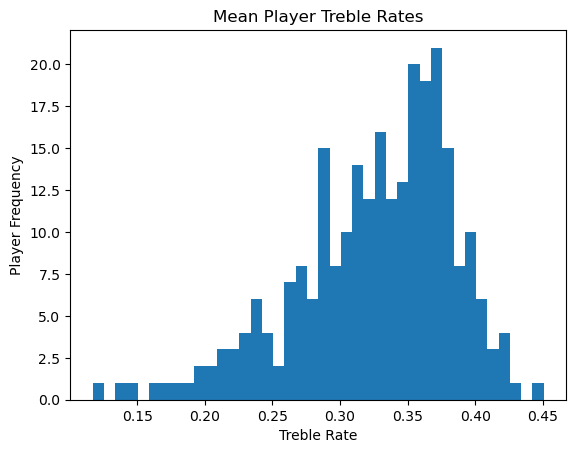

In [10]:
# We can investigate the mean treble rate of individual players
t_means = {}
list_t_means = []
# Extract overall treble hit rate
for p in player_stats:
    mean_i = sum(player_stats[p]["t_successes"])/sum(player_stats[p]["t_attempts"])
    t_means[p] = mean_i
    list_t_means.append(mean_i)
# Plot histogram
plt.hist(list_t_means, bins = 40);
plt.ylabel("Player Frequency");
plt.xlabel("Treble Rate");
plt.title("Mean Player Treble Rates");

In [11]:
# Lets see the top n players in this category
sorted_t_means = dict(sorted(t_means.items(), key=lambda item: item[1], reverse=True))
n_print = 10
i = 0
min_legs = 80
print(f"Top {n_print} players by treble hitting rate")
for player in sorted_t_means:
    n = player_stats[player]["n_legs"]
    if sum(n) > min_legs:
        print(f"{player}: {sorted_t_means[player]:.3f}")
        i += 1
    if i > n_print:
        break

Top 10 players by treble hitting rate
Littler, Luke: 0.451
Humphries, Luke: 0.429
Price, Gerwyn: 0.422
Rock, Josh: 0.419
Dobey, Chris: 0.418
van Gerwen, Michael: 0.418
Anderson, Gary: 0.417
Bunting, Stephen: 0.413
van Duijvenbode, Dirk: 0.413
Clayton, Jonny: 0.407
Aspinall, Nathan: 0.405


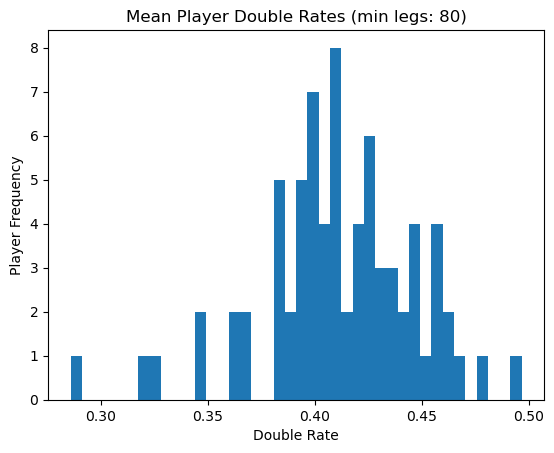

In [12]:
# We can do the same for double rate
d_means = {}
list_d_means = []
min_legs = 80
# Extract overall treble hit rate
for p in player_stats:
    n = player_stats[p]["n_legs"]
    # Add logic so that this only calculates for minimum number of legs
    if sum(n) > min_legs:
        mean_i = np.mean(player_stats[p]["d_rate"])
        d_means[p] = mean_i
        list_d_means.append(mean_i)
# Plot histogram
plt.hist(list_d_means, bins = 40);
plt.ylabel("Player Frequency");
plt.xlabel("Double Rate");
plt.title(f"Mean Player Double Rates (min legs: {min_legs})");

In [13]:
# Lets see the top n players in this category
sorted_d_means = dict(sorted(d_means.items(), key=lambda item: item[1], reverse=True))
n = 10
i = 0
print(f"Top {n} players by double success rate")
for player in sorted_d_means:
    print(f"{player}: {sorted_d_means[player]:.3f}")
    i += 1
    if i > n:
        break

Top 10 players by double success rate
Taylor, Dom: 0.497
van Veen, Gian: 0.480
Bialecki, Sebastian: 0.470
Heta, Damon: 0.464
Dekker, Cor: 0.461
Anderson, Gary: 0.460
Price, Gerwyn: 0.459
Springer, Niko: 0.459
Nijman, Wessel: 0.458
Littler, Luke: 0.451
Smith, Ross: 0.448


Far less predictable than the top players by treble rate! There is a slight limitation to my data meaning that I have had to calculate double success rate a different way which may introduce error.

## Match Simulations

Now using this data, I want to be able to predict the probability of players winning matches and the most likely scorelines.

### The simulation:
The full script that these functions are written in can be found on my Github page (jamesbolus). Essentially, I wrote functions for three different purposes which I will briefly explain below:

#### 1. Simulating a throw
To simulate player $i$'s throw, the function takes 3 parameters:
- The player's score
- The player's probability of hitting a treble $(t_i)$.
- The player's probability of hitting a double $(d_i)$.

At each dart, the function determines a target using a predefined dictionary that depends on the current score and the number of darts remaining. For example, a score of 320 targets a scoring treble, while a score of 48 targets single 16s to leave double 16.

The outcome of each throw is simulated as follows:

- **Treble targets** are hit with success probability $t_i$. On a miss, the corresponding single is scored. For a purely scoring target where the treble does not necessarily matter, there is a fixed probability of the player aiming for 19s rather than 20s, much like in a real match.
- **Double targets** are hit with probability $d_i$. If the double is missed, the player will score the single number or miss the board entirely with equal probability. Bust rules are enforced to simulate the disadvantage faced when aiming for lower doubles.
- **Single targets** are assumed to be hit with probability 1.

The function tracks the remaining darts and updates the score after each throw. If a checkout is achieved, the throw ends immediately. 
The function returns the resulting score as well as a Boolean value indicating whether the player has checked out.

#### 2. Simulating a leg
- The leg function simulates a leg of darts between 2 players, both starting on 501 points, until 1 player successfully checks out.
- Additionally to the parameters required in the throw function, the leg function takes and indicator of whether player 0 (home) or 1 (away) is to throw first.
- The function begins with both players on 501 points and uses the throw function until one of these players successfully checks out.
- The function returns 0 if the home player wins the leg, or 1 if the away player does.


#### 3. Simulating a match
- Two match functions exist, one for a leg-based match and one for a set-based match.
- Given a best-of value, the function will repeatedly call the leg function until either player reaches the winning score.
- Throws are alternated throughout the match in the correct fashion.


### Moving Average Model

I will now test the functions by attempting to predict the best of 21, 2025 Player's Championship Final between Luke Littler and Nathan Aspinall. I have determined the players double and treble success rates by simply taking the average of each in their last 100 legs.

In [18]:
legs_period = 100
n_sims = 10000

row = match_df.loc[1607, :]

# Extracting match specific statistics
best_of = int(max(row["home_score"], row["away_score"])*2 - 1)
home = row["home"]
away = row["away"]
date = row["date_sort"]
start_throw = row["throw"]

# Find the index that the last date was
home_idx = bisect.bisect_left(player_stats[home]["dates"], date)
away_idx = bisect.bisect_left(player_stats[away]["dates"], date)

# Extracting previous treble rates and predicting the next by taking the mean
home_trs = player_stats[home]["t_rate"][:home_idx][-legs_period:]
away_trs = player_stats[away]["t_rate"][:away_idx][-legs_period:]
home_pred_t = np.mean(home_trs)
away_pred_t = np.mean(away_trs)

# Extracting previous double rates and predicting the next by taking the mean
home_drs = player_stats[home]["d_rate"][:home_idx][-legs_period:]
away_drs = player_stats[away]["d_rate"][:away_idx][-legs_period:]
home_pred_d = np.mean(home_drs)
away_pred_d = np.mean(away_drs)


home_wins = 0
away_wins = 0
score_freq = {}
for i in range(n_sims):
    score, winner = leg_match(best_of, home_pred_t, home_pred_d, away_pred_t, away_pred_d, start_throw)
    if winner == 0:
        home_wins += 1
    else:
        away_wins += 1
        
    if score not in score_freq:
        score_freq[score] = 0
    score_freq[score] += 1

home_wins = home_wins/n_sims
away_wins = away_wins/n_sims

sorted_scores = dict(sorted(score_freq.items(), key=lambda item: item[1], reverse=True))

print(f"Predicted {home} win rate: {home_wins:.3f}. Implied (by odds) win rate: {(1/row["home_sp"]):.3f}")
print(f"Predicted {away} win rate: {away_wins:.3f}. Implied (by odds) win rate: {(1/row["away_sp"]):.3f}")
print(f"Predicted most likely scores (Actual score: {row["home_score"]} - {row["away_score"]}):")
i = 0
for score in sorted_scores:
    print(f"{score}: {sorted_scores[score]/100} %")
    i += 1
    if i > 5:
        break

Predicted Littler, Luke win rate: 0.812. Implied (by odds) win rate: 0.833
Predicted Aspinall, Nathan win rate: 0.188. Implied (by odds) win rate: 0.175
Predicted most likely scores (Actual score: 11 - 8):
11 - 8: 14.85 %
11 - 6: 14.57 %
11 - 10: 10.81 %
11 - 4: 10.05 %
11 - 7: 8.45 %
11 - 5: 7.91 %


### Backtesting this strategy

I will now "backtest" this simulation strategy by cycling through each match in the dataframe and predicting the game using this strategy. Once match probabilities are computed, bet sizes are computed by comparing starting prices to probabilites.

In [19]:
legs_period = 100 # Minimum number of legs needed to forecast the players treble rate.
n_sims = 5000 # Number of simulations per match.
k = 1

for _, row in df_with_sp.iterrows():
    # Extracting match specific statistics
    best_of = int(max(row["home_score"], row["away_score"])*2 - 1)
    home = row["home"]
    away = row["away"]
    date = row["date_sort"]
    start_throw = row["throw"]

    # Find the index that the last date was
    home_idx = bisect.bisect_left(player_stats[home]["dates"], date)
    away_idx = bisect.bisect_left(player_stats[away]["dates"], date)

    # Extracting previous rates
    home_trs = player_stats[home]["t_rate"][:home_idx][-legs_period:]
    away_trs = player_stats[away]["t_rate"][:away_idx][-legs_period:]
    home_drs = player_stats[home]["d_rate"][:home_idx][-legs_period:]
    away_drs = player_stats[away]["d_rate"][:away_idx][-legs_period:]

    if ((len(home_trs) > min_legs) and (len(away_trs) > min_legs)): # Check if there are enough previous legs for each player.
        # Predict treble and double rates
        home_pred_t = np.mean(home_trs)
        away_pred_t = np.mean(away_trs)
        home_pred_d = np.mean(home_drs)
        away_pred_d = np.mean(away_drs)
        
        home_wins = 0
        away_wins = 0
        score_freq = {}
        for i in range(n_sims):
            score, winner = leg_match(best_of, home_pred_t, home_pred_d, away_pred_t, away_pred_d, start_throw)
            if winner == 0:
                home_wins += 1
            else:
                away_wins += 1
                
            if score not in score_freq:
                score_freq[score] = 0
            score_freq[score] += 1
        
        home_wins = home_wins/n_sims
        away_wins = away_wins/n_sims

        new_row = {"date_sort":date, "competition":row["competition"], "home":home,
                   "away":away, "winner":row["winner"], "home_score":row["home_score"], 
                   "away_score":row["away_score"], "home_prob":home_wins, "away_prob":away_wins,
                   "home_sp":row["home_sp"], "away_sp":row["away_sp"]}
        new_df = pd.DataFrame([new_row])
        if k:
            results_df = new_df
            k = None
        else:
            results_df = pd.concat([results_df, new_df], ignore_index=True)

In [20]:
results_df.head(5)

,date_sort,competition,home,away,winner,home_score,away_score,home_prob,away_prob,home_sp,away_sp
0,2025-03-06 22:35:00,Darts Premier League,"Littler, Luke","Aspinall, Nathan",0,6,3,0.8302,0.1698,1.25,5.00
1,2025-03-13 19:15:00,Darts Premier League,"Humphries, Luke","Littler, Luke",1,4,6,0.2812,0.7188,2.52,1.65
2,2025-03-13 20:45:00,Darts Premier League,"Aspinall, Nathan","van Gerwen, Michael",1,4,6,0.4418,0.5582,2.50,1.66
3,2025-03-13 21:25:00,Darts Premier League,"Littler, Luke","Cross, Rob",0,6,3,0.6904,0.3096,1.30,4.00
4,2025-03-13 21:50:00,Darts Premier League,"Price, Gerwyn","van Gerwen, Michael",0,6,1,0.5340,0.4660,2.00,2.00


 Now that we have a results dataframe, we can backtest using a number of functions.

In [21]:
def half_kelly(bankroll, odds, prob_win):
    """
    Returns a stake amount based on the (half) Kelly Criterion.
    """
    amount = 0.5*bankroll*(((odds-1)*prob_win+prob_win-1)/odds)
    if amount < 0:
        return 0
    return amount

In [22]:
def payoff(bet, winner, stake, odds):
    """
    Returns the realised payoff of a given bet.
    """
    if winner == bet:
        return stake*(odds-1)
    else:
        return -stake

In [23]:
def backtest(df, bankroll, stake_function):
    """
    Backtests a strategy based on a stake function and a df containing predicted probabilites and odds.
    """
    bankroll_history = []
    stakes = []
    bet_accuracy = 0
    for _, row in df.iterrows():
        winner = row["winner"]
        home_sp = row["home_sp"]
        away_sp = row["away_sp"]
        home_prob = row["home_prob"]
        away_prob = row["away_prob"]
        if home_prob > 1/home_sp:
            stake = stake_function(bankroll, home_sp, home_prob)
            stakes.append(stake)
            if winner == 0:
                bankroll += stake*(home_sp-1)
                bet_accuracy += 1
            else:
                bankroll -= stake
        else:
            stake = stake_function(bankroll, away_sp, away_prob)
            stakes.append(stake)
            if winner == 1:
                bankroll += stake*(away_sp-1)
                bet_accuracy += 1
            else:
                bankroll -= stake

        bankroll_history.append(bankroll)
    bet_accuracy = bet_accuracy/len(df)

    bets = np.where(df["home_prob"] > 1/df["home_sp"], 0, 1)
    bet_results = df.copy()
    bet_results["bet"] = bets
    bet_results["stake"] = stakes
    bet_results["bankroll"] = bankroll_history
    return bankroll_history, bet_accuracy, bet_results

In [24]:
starting_bankroll = 1000
bankroll_history, bet_acc, bet_results = backtest(results_df, starting_bankroll, half_kelly)

In [25]:
bet_results.head(5)

,date_sort,competition,home,away,winner,home_score,away_score,home_prob,away_prob,home_sp,away_sp,bet,stake,bankroll
0,2025-03-06 22:35:00,Darts Premier League,"Littler, Luke","Aspinall, Nathan",0,6,3,0.8302,0.1698,1.25,5.00,0,15.100000,1003.775000
1,2025-03-13 19:15:00,Darts Premier League,"Humphries, Luke","Littler, Luke",1,4,6,0.2812,0.7188,2.52,1.65,1,56.582493,1040.553620
2,2025-03-13 20:45:00,Darts Premier League,"Aspinall, Nathan","van Gerwen, Michael",1,4,6,0.4418,0.5582,2.50,1.66,0,21.747571,1018.806050
3,2025-03-13 21:25:00,Darts Premier League,"Littler, Luke","Cross, Rob",0,6,3,0.6904,0.3096,1.30,4.00,1,30.360420,988.445629
4,2025-03-13 21:50:00,Darts Premier League,"Price, Gerwyn","van Gerwen, Michael",0,6,1,0.5340,0.4660,2.00,2.00,0,16.803576,1005.249205


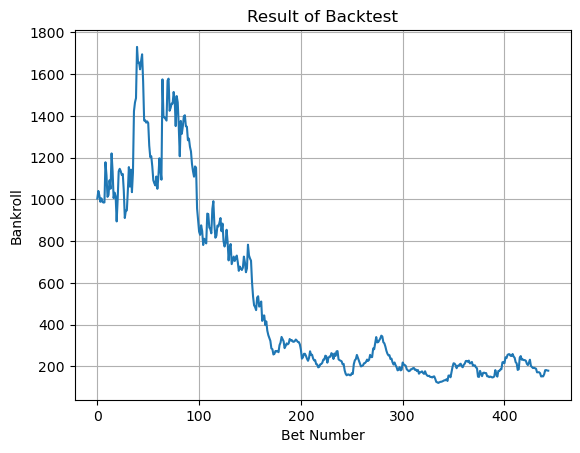

In [26]:
plt.plot(bankroll_history)
plt.title("Result of Backtest")
plt.ylabel("Bankroll")
plt.xlabel("Bet Number")
plt.grid()

Unsurpringly, the strategy that does not take either player's recent/tournament form into account fails to return a profit. A more sophisticated method of forecasting a player's treble/double rate would take more recent performances into account, possibly in the form of a moving average or taking a Bayesian approach.

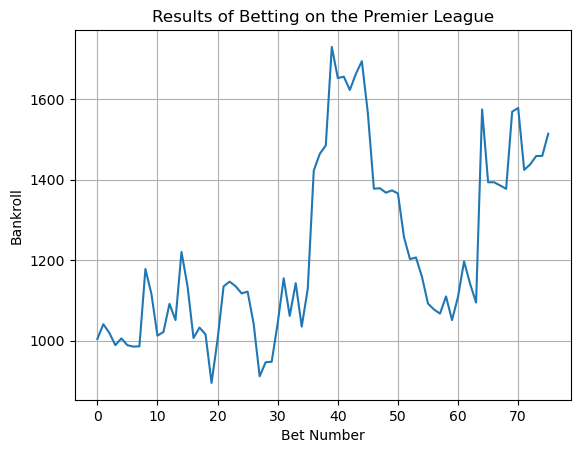

In [27]:
prem_results = results_df[results_df["competition"] == "Darts Premier League"]

bankroll_history_prem, bet_acc_prem, bet_results_prem = backtest(prem_results, starting_bankroll, half_kelly)

plt.plot(bankroll_history_prem)
plt.title("Results of Betting on the Premier League")
plt.ylabel("Bankroll")
plt.xlabel("Bet Number")
plt.grid()

### Predicting the 2026 PDC Darts World Championship

Using the same simulation technique, I will attempt to predict the 2026 PDC World Championship which has just occured.

In [28]:
def set_match(best_of, home_tr, home_dr, away_tr, away_dr, start_throw):
    """
    Simulates a set format match.
    """
    next_throw = start_throw
    home_sets = 0
    away_sets = 0
    win_score = (best_of//2) + 1
    home_legs = 0
    away_legs = 0

    while max(home_sets, away_sets) < win_score:
        winner = leg(next_throw, home_tr, home_dr, away_tr, away_dr) # Simulate 1 leg
        next_throw = 1 if next_throw == 0 else 0 # Update for next throw
        # Update scores
        if winner == 0:
            home_legs += 1
            if home_legs == 3:
                home_sets += 1
                home_legs = 0
                away_legs = 0
                tot_sets = home_sets + away_sets
                next_throw = start_throw if (tot_sets%2)==0 else (start_throw+1)%2
        elif winner == 1:
            away_legs += 1
            if away_legs == 3:
                away_sets += 1
                home_legs = 0
                away_legs = 0
                tot_sets = home_sets + away_sets
                next_throw = start_throw if (tot_sets%2)==0 else (start_throw+1)%2

    score = (home_sets, away_sets)
    if home_sets > away_sets:
        match_winner = 0
    elif away_sets > home_sets:
        match_winner = 1

    return score, match_winner

In [29]:
def simulate_round(players, best_of, predicted_stats):
    """
    Simulates a round from a list of players (index i plays index i+1) and returns the winners. Takes a dictionary of predicted stats
    with treble and double rates for each player.
    """
    winners = []

    for i in range(0, len(players), 2):
        home = players[i]
        away = players[i + 1]

        # Alternate start throw as random
        start_throw = (i // 2) % 2

        home_tr = predicted_stats[home]["t_rate"]
        home_dr = predicted_stats[home]["d_rate"]
        away_tr = predicted_stats[away]["t_rate"]
        away_dr = predicted_stats[away]["d_rate"]

        _, match_winner = set_match(best_of, home_tr, home_dr, away_tr, away_dr, start_throw)

        winners.append(home if match_winner == 0 else away)

    return winners

In [30]:
def simulate_wc(players, round_best_of, predicted_stats, round_function):
    """
    Simulates a knockout bracket.
    """
    # Check input dimensions
    expected_ps = 2 ** len(round_best_of)
    if len(players) != expected_ps:
        raise ValueError(f"wrong input dimensions: got {len(players)}, expected {expected_ps}")

    # Simulate bracket
    players_left = players
    for best_of in round_best_of:
        players_left = round_function(players_left, best_of, predicted_stats)

    return players_left[0] 

In [31]:
# Read in full draw
full_draw = pd.read_csv("2026_wc_draw.csv", header=None)
full_draw = full_draw[0].to_list()

In [32]:
# Check players with no stats
for p in full_draw:
    if p not in player_stats:
        print(p)

Davies, David
Cameron, David
Zong, Xiaochen
Kumar, Nitin
Sakai, Motomu
Lim, Paul
Munyua, David
Azemoto, Ryusei
Lok Leung, Man
Manby, Charlie
Reyes, Cristo
Tatsunami, Mitsuhiko
Nebrida, Paolo
Salate, Jesus
Kovacs, Patrik


To determine each player's predicted stats, I will use an average of the last 300 legs that a player has played. If a player has incomplete data (less than 300 legs), I will use a weighted sum of the observed treble rate and predicted population rate.

In [33]:
# Make dictionary of predicted player stats
predicted_stats = {}
min_t_legs = 300
min_d_legs = 300

# We will assume that the standard player treble and double rates for incomplete data are the 20% quantile of the population.
av_t_rate = np.quantile(list_t_means, 0.20)
av_d_rate = np.quantile(list_d_means, 0.20)

for player in full_draw:
    # Extract list of historic treble and double rates
    predicted_stats[player] = {}

    try:
        t_rates = player_stats[player]["t_rate"][-min_t_legs:]
        d_rates = player_stats[player]["d_rate"][-min_d_legs:]
    except:
        t_rates = []
        d_rates = []    

    pred_t_rate = ((min_t_legs-len(t_rates))*av_t_rate + sum(t_rates))/min_t_legs
    pred_d_rate = ((min_d_legs-len(d_rates))*av_d_rate + sum(d_rates))/min_d_legs
    predicted_stats[player]["t_rate"] = pred_t_rate
    predicted_stats[player]["d_rate"] = pred_d_rate

In [34]:
winners = {}
round_best_of = [5, 5, 7, 7, 9, 11, 13]
n_tournament_sims = 5000

for i in range(n_tournament_sims):
    winner = simulate_wc(full_draw, round_best_of, predicted_stats, simulate_round)
    if winner not in winners:
        winners[winner] = 0
    winners[winner] += 1

In [35]:
pdc_wc_winners = dict(sorted(winners.items(), key=lambda item: item[1], reverse=True))

for player in pdc_wc_winners:
    print(f"{player} : {100*pdc_wc_winners[player]/n_tournament_sims}%")

Littler, Luke : 55.0%
van Veen, Gian : 10.04%
Price, Gerwyn : 8.22%
Humphries, Luke : 6.88%
Noppert, Danny : 3.84%
van Gerwen, Michael : 2.38%
Aspinall, Nathan : 2.38%
Anderson, Gary : 2.26%
Dobey, Chris : 2.0%
Bunting, Stephen : 1.72%
Clayton, Jonny : 1.7%
Rock, Josh : 0.74%
Nijman, Wessel : 0.72%
Schindler, Martin : 0.44%
Chisnall, Dave : 0.42%
Smith, Ross : 0.34%
Searle, Ryan : 0.34%
van Duijvenbode, Dirk : 0.2%
Cross, Rob : 0.12%
Wattimena, Jermaine : 0.12%
Springer, Niko : 0.04%
Wade, James : 0.04%
Heta, Damon : 0.04%
Woodhouse, Luke : 0.02%


A slightly more realistic model may introduce some performance variance. To do this, rather than predicting a constant treble rate for each player, I will introduce some error based on each player's historical treble and double rate variance. Error for player i is formulated as follows:
$$
\epsilon_{t,i} \sim \mathbb{N}(0, \sigma_{t,i}^2), \: \: \: \: \:
\epsilon_{d,i} \sim \mathbb{N}(0, \sigma_{d,i}^2)
$$

Where $\sigma_{d,i}$ and $\sigma_{t,i}$ is the player i's double and treble rate variance respectively.

In [36]:
match_player_statistics = {}
all_treb_rates = []
all_dbl_rates = []
for _, row in match_df.iterrows():
    home = row["home"]
    away = row["away"]
    if home not in match_player_statistics:
        match_player_statistics[home] = {"t_rate":[], "d_rate":[]}
    if away not in match_player_statistics:
        match_player_statistics[away] = {"t_rate":[], "d_rate":[]}

    match_player_statistics[home]["t_rate"].append(row["home_treb_rate"])
    match_player_statistics[home]["d_rate"].append(row["home_checkout_percentage"]/100)
    match_player_statistics[away]["t_rate"].append(row["away_treb_rate"])
    match_player_statistics[away]["d_rate"].append(row["away_checkout_percentage"]/100)
    
    all_treb_rates.append(row["home_treb_rate"])
    all_treb_rates.append(row["away_treb_rate"])
    all_dbl_rates.append(row["home_checkout_percentage"]/100)
    all_dbl_rates.append(row["away_checkout_percentage"]/100)

In [37]:
# Make a dictionary for treble and double rate variance per player
variances = {}
for player in match_player_statistics:
    t_v = np.var(match_player_statistics[player]["t_rate"])
    d_v = np.var(match_player_statistics[player]["d_rate"])
    n = len(match_player_statistics[player]["t_rate"])
    variances[player] = {"treb": t_v, "dbl": d_v, "n": n}

In [38]:
# Add a treble and double variance to all players in predicted stats
mean_treb_var = np.var(all_treb_rates)
mean_dbl_var = np.var(all_dbl_rates)
for player in full_draw:
    try:
        predicted_stats[player]["treb_var"] = variances[player]["treb"]
        predicted_stats[player]["dbl_var"] = variances[player]["dbl"]
    except:
        predicted_stats[player]["treb_var"] = mean_treb_var
        predicted_stats[player]["dbl_var"] = mean_dbl_var

In [39]:
from scipy.stats import norm
def simulate_round_with_variance(players, best_of, predicted_stats):
    """
    Simulates a round from a list of players (index i plays index i+1) and returns the winners. Takes a dictionary of predicted stats
    with treble and double rates for each player.
    """
    winners = []

    for i in range(0, len(players), 2):
        home = players[i]
        away = players[i + 1]

        # Alternate start throw as random
        start_throw = (i // 2) % 2

        home_tr = predicted_stats[home]["t_rate"] + norm.rvs(0, predicted_stats[home]["treb_var"])
        home_dr = predicted_stats[home]["d_rate"] + norm.rvs(0, predicted_stats[home]["dbl_var"])
        away_tr = predicted_stats[away]["t_rate"] + norm.rvs(0, predicted_stats[away]["treb_var"])
        away_dr = predicted_stats[away]["d_rate"] + norm.rvs(0, predicted_stats[away]["dbl_var"])

        _, match_winner = set_match(best_of, home_tr, home_dr, away_tr, away_dr, start_throw)

        winners.append(home if match_winner == 0 else away)

    return winners

In [40]:
winners_var = {}
round_best_of = [5, 5, 7, 7, 9, 11, 13]
n_tournament_sims = 5000

for i in range(n_tournament_sims):
    winner = simulate_wc(full_draw, round_best_of, predicted_stats, simulate_round_with_variance)
    if winner not in winners_var:
        winners_var[winner] = 0
    winners_var[winner] += 1

In [41]:
pdc_wc_winners_var = dict(sorted(winners_var.items(), key=lambda item: item[1], reverse=True))

for player in pdc_wc_winners_var:
    print(f"{player} : {100*pdc_wc_winners_var[player]/n_tournament_sims}%")

Littler, Luke : 54.7%
van Veen, Gian : 9.52%
Price, Gerwyn : 7.68%
Humphries, Luke : 6.86%
Noppert, Danny : 3.76%
Aspinall, Nathan : 2.82%
van Gerwen, Michael : 2.28%
Anderson, Gary : 2.12%
Dobey, Chris : 1.96%
Bunting, Stephen : 1.76%
Clayton, Jonny : 1.46%
Nijman, Wessel : 0.92%
Rock, Josh : 0.9%
Smith, Ross : 0.58%
Schindler, Martin : 0.56%
Searle, Ryan : 0.48%
van Duijvenbode, Dirk : 0.48%
Cross, Rob : 0.38%
Chisnall, Dave : 0.36%
Wattimena, Jermaine : 0.1%
Springer, Niko : 0.1%
Menzies, Cameron : 0.06%
Heta, Damon : 0.06%
Gurney, Daryl : 0.04%
Smith, Michael : 0.04%
Woodhouse, Luke : 0.02%


From Oddschecker, the starting prices were actually as follows:

- Littler, Luke: 54%  
- Humphries, Luke: 14%  
- van Veen, Gian: 8%  
- Rock, Josh: 5%  
- Price, Gerwyn: 4%  
- van Gerwen, Michael: 4%  
- Anderson, Gary: 3%  
- Bunting, Stephen: 2%  
- Noppert, Danny: 1.5%  
- Nijman, Wessel: 1.5%  
- Aspinall, Nathan: 1.5%

It is interesting to see the model rating Littler as highly as the betting markets. Before the tournament, I thought his starting price was clearly somewhat inflated by hype and recency bias... clearly he has been playing well enough to deserve this!

<style>
/* Wrap code cells when exporting/printing */
div.output pre, 
div.input pre, 
pre {
    white-space: pre-wrap !important;
    word-wrap: break-word !important;
    overflow-x: auto !important;
}
</style>
